# Подгружаем библиотеки и данные

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
from pycalphad import Database

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import aesara
import scipy
import seaborn as sns

# пути к tdb
db18 = Database('tdbs/CoCr-18Cac_with_new_functions.tdb')
db10 = Database('tdbs/CoCr-01Oik_with_new_functions.tdb')

# пути к опытным данным
path_sigma_fcc = 'emp_data/sigma_fcc_allibert.xls'
path_sigma_hcp = 'emp_data/sigma_hcp_allibert.xls'
path_bcc = 'emp_data/sigma_bcc_allibert.xls'

# подгрузка и преобразование опытных данных при концентрации хрома 0.5
df_sigma_fcc = pd.read_excel(path_sigma_fcc)
df_sigma_hcp = pd.read_excel(path_sigma_hcp)

df_hcp_fcc = pd.concat([df_sigma_fcc, df_sigma_hcp])

df_hcp_fcc['T'] = df_hcp_fcc['T'].round(2)
df_hcp_fcc['cr_conc'] = df_hcp_fcc['cr_conc'].round(6)
df_hcp_fcc = df_hcp_fcc[(df_hcp_fcc['phase'] == 'sigma_old')].reset_index()
df_hcp_fcc.sort_values('T', inplace=True)

y_obs_05 = df_hcp_fcc['cr_conc'].values
t_05 = df_hcp_fcc['T'].to_numpy()

# подгрузка и преобразование опытных данных при концентрации хрома 0.75
df_bcc = pd.read_excel(path_bcc)

df_bcc['T'] = df_bcc['T'].round(2)
df_bcc['cr_conc'] = df_bcc['cr_conc'].round(6)
df_bcc = df_bcc[(df_bcc['phase'] == 'sigma_old')].reset_index()
df_bcc.sort_values('T', inplace=True)

y_obs_75 = df_bcc['cr_conc'].values
t_75 = df_bcc['T'].to_numpy()

# подгрузка и преобразование расчетных данных
trace18 = az.from_json('calc_res/trace_cocr18_2Sx700x1000x2_20230509.json')
ppc18 = az.from_json('calc_res/ppc_cocr18_2Sx700x1000x2_20230509.json')
pp18 = az.from_json('calc_res/pp_cocr18_2Sx2000_20230509.json')
main18 = trace18.extend(ppc18)
par_list18 = ['GSCRCO1', 'GSCOCRCO1', 'GSCOCRCO2', 'GSCRCO2', 'GSCOCR1',  'GSCOCR2', 'GSCOCR3']

trace10 = az.from_json('calc_res/trace_cocr10_2Sx700x1000x4.json')
ppc10 = az.from_json('calc_res/ppc_cocr10_2Sx700x1000x4.json')
pp10 = az.from_json('calc_res/pp_cocr10_2Sx4000.json')
main10 = trace10.extend(ppc10)
par_list10 = ['SIGMA_OLD_COCRCO_0', 'SIGMA_OLD_COCRCO_1', 'SIGMA_OLD_COCRCR_0', 'SIGMA_OLD_COCRCR_1']


print(f"Running on PyMC v{pm.__version__}") # 5.3.1 or 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


# Определяем функции

In [2]:
# запись словаря со значениями параметров по tdb
def from_piecewise_to_dict(db, parameters_list):
    import sympy
    full_par_dict = db.symbols
    tdb_par_dict = dict()

    for par in parameters_list:
        tdb_par_dict[par] = np.float32(full_par_dict[par].args_as_sympy()[0])
    return tdb_par_dict

# собираем цепи в одну для каждого параметра, словарь
def chains_concatenate(traces, parameters_list):
    # создаем словарь с распределениями параметров
    par_chains_dict = dict()
    for par in parameters_list:
        par_chains_dict[par] = np.float32(np.concatenate(traces.posterior.variables[par]))
    
    # вычисляем объем каждого сэмпла
    chains_num = traces.sample_stats.chain.data.shape
    draws_num = traces.sample_stats.draw.data.shape
    num_points = chains_num[0]*draws_num[0]
    
    return par_chains_dict

def chain_size(traces):
    # создаем словарь с распределениями параметров
    chains_num = traces.sample_stats.chain.data.shape
    draws_num = traces.sample_stats.draw.data.shape
    num_points = chains_num[0]*draws_num[0]
    
    return num_points

# для каждого распределения параметра считаем распределение квадратов отклонений от значения в tdb
def mse_dictribution_dict(par_chains_dict, tdb_par_dict, par_list):
    mse_par_dict = dict()

    for par in par_list:
        mse_par_dict[par] = np.float_power(np.subtract(par_chains_dict[par], tdb_par_dict[par]), 2)

    return mse_par_dict

# выдает словарь где для каждой температуры есть распределение предсказанных для нее значений
def from_ppc_to_temp_dict(ppc, var_name_str):
    yt_dict = dict()
    ppc_conc = np.concatenate(ppc.posterior_predictive.data_vars[var_name_str].data)
    t_num = ppc_conc.shape[1]
    p_num = ppc_conc.shape[0]
    
    for i in range(t_num):
        i_list = []
        
        for j in range(p_num):
            i_list.append(ppc_conc[j][i])

        yt_dict[i] = i_list # key = индекс температуры в T
    return yt_dict

# выдает словари с аопстериорной вероятностью каждого параметра и с логарифмом вероятности
def ppp_and_lnppp_dict_calc(di, par_list, mse_par_dict, num):
    import scipy

    ppp_dict = dict()
    ln_ppp_dict = dict()
    di = 0.000001
    # num = len(mse_par_dict[0])

    for par in par_list:
        list_cnt = [x for x in mse_par_dict[par] if x <= di]

        if len(list_cnt) == 0:
            print(par)
            mean = np.mean(mse_par_dict[par])
            std = np.std(mse_par_dict[par])
            # не подходит для любого параметра, только для норм распределнного
            ppp_dict[par] = scipy.stats.norm(mean, std).pdf(di)
        else:
            # print(par)
            # print(len(list_cnt))
            # print(num)
            ppp_dict[par] = len(list_cnt)/num

        ln_ppp_dict[par] = np.log(ppp_dict[par])

    return ln_ppp_dict, ppp_dict

# вычисление логарифма апостериорной вероятности модели на основе словаря
def model_lnpp_calc(par_list, ln_ppp_dict):
    ppp = 0

    for par in par_list:
        ppp += ln_ppp_dict[par]
    return ppp

# Считаем метрики

In [3]:
tdb_par_dict10 = from_piecewise_to_dict(db10, par_list10)
tdb_par_dict18 = from_piecewise_to_dict(db18, par_list18)

par_dict10 = chains_concatenate(trace10, par_list10)
par_dict18 = chains_concatenate(trace18, par_list18)

num10 = chain_size(trace10)
num18 = chain_size(trace18)

mse_par_dict10 = mse_dictribution_dict(par_dict10, tdb_par_dict10, par_list10)
mse_par_dict18 = mse_dictribution_dict(par_dict18, tdb_par_dict18, par_list18)

ln_ppp_dict10, ppp_dict10 = ppp_and_lnppp_dict_calc(0.000001,par_list10, mse_par_dict10, num10)
ln_ppp_dict18, ppp_dict18 = ppp_and_lnppp_dict_calc(0.000001,par_list18, mse_par_dict18, num18)

SIGMA_OLD_COCRCO_1
SIGMA_OLD_COCRCR_1


## Сравнение по отношению апостериорных вероятностей

Апостериорная вероятность $$P(M|y) = \sum_{i}{ln(P(\theta_i|y))} = \sum_{i}{ln(\frac{m_{\theta_i}}{n})}$$
где \
$m_{\theta_i}$ - число точек в распределении квадратов отклонения апостерниорных значений параметра $\theta_i$ от значения параметра в модели, которое вошло в допустимый диапазон, то есть меньше или равно  0.00001\
$n$ - общее число точек в апостериорном распределении параметра\
$i$ - число параметров модели

Если мощность множества точек, вошедших в допустимый диапазон, равно 0, то для вычисления $\frac{m_{\theta_i}}{n}$ использовалась функция библиотеки scipy:

```scipy.stats.norm(mean, std).pdf(0.00001) ```\
где ```mean``` - среднее значение в распределении квадратов отклонений параметра, а ```std``` - стандартное отклонение

Таким образом, удалось расчитать логарифм вероятности для каждого параметра

In [4]:
pp10 = model_lnpp_calc(par_list10, ln_ppp_dict10)
pp18 = model_lnpp_calc(par_list18, ln_ppp_dict18)
print(f'ln posterior probability of 10 model:{pp10}')
print(f'ln posterior probability of 18 model:{pp18}')

ln posterior probability of 10 model:-71.16073516665647
ln posterior probability of 18 model:-1.005843517326468


In [5]:
# отношение полученных значений - целевая метрика
pp_comp = np.exp(pp18 - pp10)
pp_comp

2.9368537624578374e+30

In [6]:
pp_comp = np.exp(pp10 - pp18)
pp_comp

3.4050044056776777e-31

## Вывод
Так как числа получились очень маленькими/большими, удобнее посмотреть на степени:
$e^{-71}$ < $e^{-1}$, следовательно, 10 модель сильно хуже, чем 18

## Сравнение по WAIC

In [7]:
t1005 = az.waic(trace10, var_name='y_norm_05', pointwise=True)
waic1005 = -2*t1005.elpd_waic
t1805 = az.waic(trace18, var_name='y_norm_05', pointwise=True)
waic1805 = -2*t1805.elpd_waic
print(f'waic for y_norm_05 model 10: {waic1005}')
print(f'waic for y_norm_05 model 18: {waic1805}')
t1075 = az.waic(trace10, var_name='y_norm_75', pointwise=True)
waic1075 = -2*t1075.elpd_waic
t1875 = az.waic(trace18, var_name='y_norm_75', pointwise=True)
waic1875 = -2*t1875.elpd_waic
print(f'waic for y_norm_75 model 10: {waic1075}')
print(f'waic for y_norm_75 model 18: {waic1875}')

waic for y_norm_05 model 10: 2405.2353845254406
waic for y_norm_05 model 18: 10629.097527046823
waic for y_norm_75 model 10: 7047.67048888046
waic for y_norm_75 model 18: 261193005.57875085


c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


## Вывод
10 модель лучше

## Сравнение по LOO

In [8]:
l0510 = az.loo(trace10, var_name='y_norm_05', pointwise=True)
loo0510 = -2*l0510.elpd_loo
print(f'loo for y_norm_05 model 10: {loo0510}')
l0518 = az.loo(trace18, var_name='y_norm_05', pointwise=True)
loo0518 = -2*l0518.elpd_loo
print(f'loo for y_norm_05 model 18: {loo0518}')
l7510 = az.loo(trace10, var_name='y_norm_75', pointwise=True)
loo7510 = -2*l7510.elpd_loo
print(f'loo for y_norm_75 model 10: {loo7510}')
l7518 = az.loo(trace18, var_name='y_norm_75', pointwise=True)
loo7518 = -2*l7518.elpd_loo
print(f'loo for y_norm_75 model 18: {loo7518}')


loo for y_norm_05 model 10: 2354.025375142557
loo for y_norm_05 model 18: 10629.097917254556
loo for y_norm_75 model 10: 6825.6981248636475
loo for y_norm_75 model 18: 261193005.5788179


c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\emgebrishvili\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Use

## Вывод
10 модель лучше

## Наложение ppc

[]

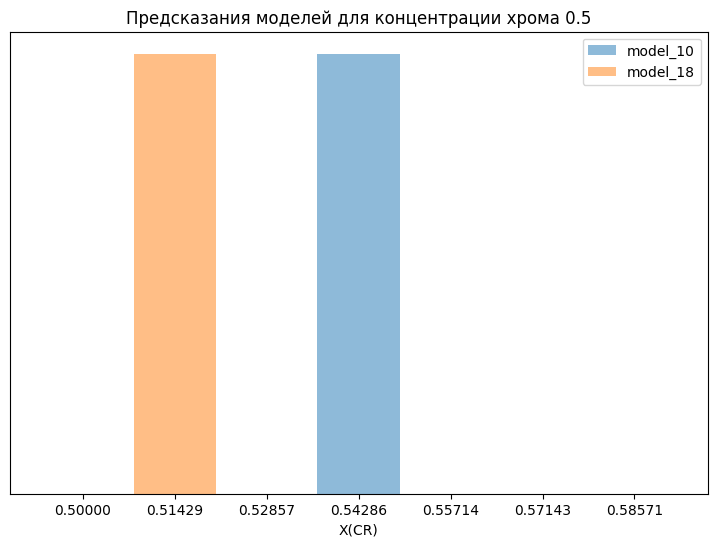

In [9]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.5, 0.6, 8)
ax = az.plot_dist(
    ppc10.posterior_predictive['y_norm_05'].mean("y_norm_05_dim_0"),
    label="model_10",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)
ax = az.plot_dist(
    ppc18.posterior_predictive["y_norm_05"].mean("y_norm_05_dim_0"),
    label="model_18",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("X(CR)")
ax.set_title('Предсказания моделей для концентрации хрома 0.5')
# ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([])

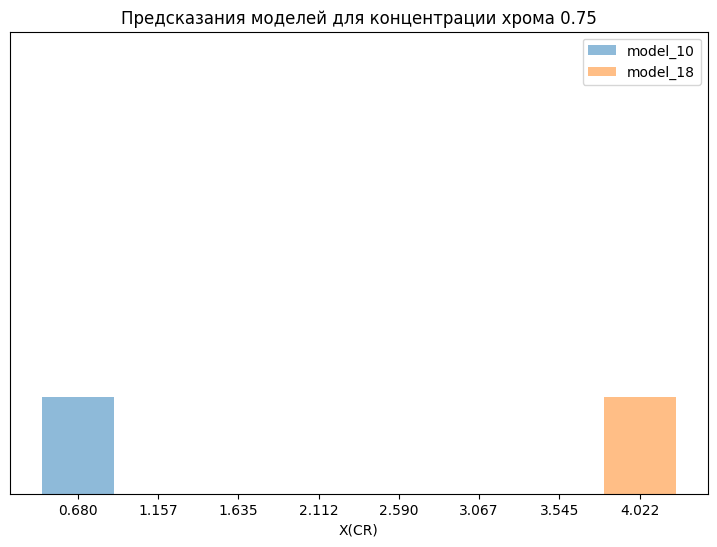

In [10]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.68, 4.5, 9)
ax = az.plot_dist(
    ppc10.posterior_predictive['y_norm_75'].mean("y_norm_75_dim_0"),
    label="model_10",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)
ax = az.plot_dist(
    ppc18.posterior_predictive["y_norm_75"].mean("y_norm_75_dim_0"),
    label="model_18",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("X(CR)")
ax.set_title('Предсказания моделей для концентрации хрома 0.75')
ax.set_ylim(0, 10)
# ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([]);

## Вывод
10 модель точнее

## График распределения

In [11]:
y_norm_05_temp_dict10 = from_ppc_to_temp_dict(ppc10, 'y_norm_05')
y_norm_75_temp_dict10 = from_ppc_to_temp_dict(ppc10, 'y_norm_75')
y_norm_05_temp_dict18 = from_ppc_to_temp_dict(ppc18, 'y_norm_05')
y_norm_75_temp_dict18 = from_ppc_to_temp_dict(ppc18, 'y_norm_75')

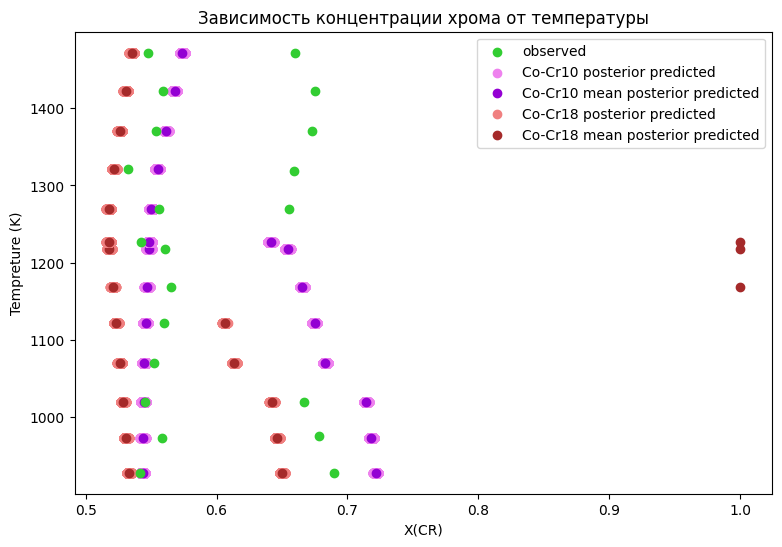

In [12]:
# Создаем фигуру и оси
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

axes.set_title('Зависимость концентрации хрома от температуры')


# Добавляем точки на график и задаем метки для легенды

for i in range(len(t_05)):
    min_0510 = np.percentile(y_norm_05_temp_dict10[i], 2.5)
    max_0510 = np.percentile(y_norm_05_temp_dict10[i], 100-2.5)
    mean_0510 = sum(y_norm_05_temp_dict10[i])/len(y_norm_05_temp_dict10[i])
    yt_0510 = [x for x in y_norm_05_temp_dict10[i] if x > min_0510 and x < max_0510]

    min_0518 = np.percentile(y_norm_05_temp_dict18[i], 2.5)
    max_0518 = np.percentile(y_norm_05_temp_dict18[i], 100-2.5)
    mean_0518 = sum(y_norm_05_temp_dict18[i])/len(y_norm_05_temp_dict18[i])
    yt_0518 = [x for x in y_norm_05_temp_dict18[i] if x > min_0518 and x < max_0518]
    
    scatter2 = axes.scatter(yt_0510, np.repeat(t_05[i], len(yt_0510)), label='Co-Cr10 posterior predicted', color = 'violet')
    scatter3 = axes.scatter(mean_0510, t_05[i], label='Co-Cr10 mean posterior predicted', color = 'darkviolet')
    scatter4 = axes.scatter(yt_0518, np.repeat(t_05[i], len(yt_0518)), label='Co-Cr18 posterior predicted', color = 'lightcoral')
    scatter5 = axes.scatter(mean_0518, t_05[i], label='Co-Cr18 mean posterior predicted', color = 'brown')


for i in range(len(t_75)):    
    min_7510 = np.percentile(y_norm_75_temp_dict10[i], 2.5)
    max_7510 = np.percentile(y_norm_75_temp_dict10[i], 100-2.5)
    y_75_1010 = [x if x < 1 else 1 for x in y_norm_75_temp_dict10[i] ]
    if len(y_75_1010) > 0:
        yt_7510 = [x for x in y_norm_75_temp_dict10[i] if x > min_7510 and x < max_7510 and x < 1]
        mean_7510 = sum(y_norm_75_temp_dict10[i])/len(y_norm_75_temp_dict10[i])
    min_7518 = np.percentile(y_norm_75_temp_dict18[i], 2.5)
    max_7518 = np.percentile(y_norm_75_temp_dict18[i], 100-2.5)
    y_75_1018 = [x if x < 1 else 1 for x in y_norm_75_temp_dict18[i]]
    # if len(y_75_1018) > 0:
    yt_7518 = [x for x in y_norm_75_temp_dict18[i] if x > min_7518 and x < max_7518 and x < 1]
    mean_7518 = sum(y_75_1018)/len(y_75_1018)
    
    scatter2 = axes.scatter(yt_7510, np.repeat(t_05[i], len(yt_0510)), label='Co-Cr10 posterior predicted', color = 'violet')
    scatter3 = axes.scatter(mean_7510, t_05[i], label='Co-Cr10 mean posterior predicted', color = 'darkviolet')
    scatter4 = axes.scatter(yt_7518, np.repeat(t_05[i], len(yt_7518)), label='Co-Cr18 posterior predicted', color = 'lightcoral')
    scatter5 = axes.scatter(mean_7518, t_05[i], label='Co-Cr18 mean posterior predicted', color = 'brown')


scatter1 = axes.scatter(y_obs_05, t_05, label='observed', color = 'limegreen')
scatter1 = axes.scatter(y_obs_75, t_75, label='observed', color = 'limegreen')

# Добавляем легенду на график
axes.legend(handles=[scatter1, scatter2, scatter3, scatter4, scatter5])

# Задаем название осей
axes.set_xlabel('X(CR)')
axes.set_ylabel('Tempreture (K)')

# Отображаем график
plt.show()

## Вывод
10 модель точнее

# Вывод
10 модель позволяет получить более точные результаты